In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score

from keras_preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

In [2]:
import lstm_preprocess

In [3]:
import os
import tensorflow as tf
import random
# fix the random seed for tensorflow models
os.environ['TF_DETERMINISTIC_OPS'] = '1' 
SEED = 39
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# set to use flexible GPU resources  
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")

Num GPUs Available: 1.


## Read the data

In [5]:
data = pd.read_csv("./icd_demos_vitals.csv")

data.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
#either keep the patients with 24 hours of admission, or change 23 to sth smaller to include patients with less time steps
df = lstm_preprocess.pad(data, 23, 24, 0)

df

,mortality,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose,hadm_id,...,18,19,20,F,M,18-25,25-45,45-65,65-89,89+
0,1.0,0.271698,0.331190,0.248120,0.251678,0.144928,0.000000,0.93,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.283019,0.299035,0.240602,0.241611,0.130435,0.000000,0.91,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.275472,0.347267,0.229323,0.238255,0.144928,0.000000,0.94,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.283019,0.344051,0.221805,0.238255,0.260870,0.000000,0.95,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.298113,0.379421,0.323308,0.305369,0.231884,0.000000,0.95,0.0,100061.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53131,0.0,0.305660,0.331190,0.203008,0.224832,0.246377,0.872200,0.94,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53132,0.0,0.298113,0.356913,0.195489,0.218121,0.275362,0.000000,0.00,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53133,0.0,0.279245,0.382637,0.233083,0.251678,0.333333,0.000000,0.00,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53134,0.0,0.305660,0.389068,0.236842,0.261745,0.231884,0.000000,0.00,0.0,199984.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
#remove unnecessary columns
COLUMNS = lstm_preprocess.delete_columns(df)

COLUMNS

['heartrate',
 'sysbp',
 'diasbp',
 'meanbp',
 'resprate',
 'tempc',
 'spo2',
 'glucose',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 'F',
 'M',
 '18-25',
 '25-45',
 '45-65',
 '65-89',
 '89+']

In [8]:
hadm_idx = df['hadm_id'].values.reshape(-1, 24, 1)[:, 0, 0]
hadm_idx

array([100061., 100087., 100104., ..., 199976., 199981., 199984.])

In [9]:
#reshape the matrix to the appropriate format
MATRIX = df[COLUMNS+['mortality']].values
MATRIX = MATRIX.reshape(int(MATRIX.shape[0]/24),24,MATRIX.shape[1])

In [10]:
bool_matrix = (~MATRIX.any(axis=2))
MATRIX[bool_matrix] = np.nan
# MATRIX = lstm_preprocess.ZScoreNormalize(MATRIX)

## restore 3D shape to boolmatrix for consistency
bool_matrix = np.isnan(MATRIX)
MATRIX[bool_matrix] = 0 
   
#permutation = np.random.permutation(MATRIX.shape[0])
#MATRIX = MATRIX[permutation]
#bool_matrix = bool_matrix[permutation]

# X_MATRIX = MATRIX[:,:,0:-1]
X_MATRIX = MATRIX[:,:,0:-2] # only use the first 8 temporal features, ignoring demographic data for now
Y_MATRIX = MATRIX[:,:,-1]
sc = MinMaxScaler()
#x_bool_matrix = bool_matrix[:,:,0:-1]
#y_bool_matrix = bool_matrix[:,:,-1]

In [11]:
X_MATRIX[0].shape

(24, 34)

In [12]:
pd.value_counts(Y_MATRIX[:, 0])

0.0    1819
1.0     395
dtype: int64

In [13]:
#train, validation, test split
tt_split = 0.7 
val_percentage = 0.8

train_tail_idx = int(tt_split*X_MATRIX.shape[0])
val_tail_idx = int(val_percentage*X_MATRIX.shape[0])

In [14]:
# extract the admission idx for train/validation/test, used to extract text patient data for prediction 
train_hadm_idx = hadm_idx[:train_tail_idx]
val_hadm_idx = hadm_idx[train_tail_idx:val_tail_idx]
test_hadm_idx = hadm_idx[val_tail_idx::]

In [15]:
X_TRAIN = X_MATRIX[0:train_tail_idx, :, :]
Y_TRAIN = Y_MATRIX[0:train_tail_idx, 0]
# Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], Y_TRAIN.shape[1], 1)

X_VAL = X_MATRIX[train_tail_idx:val_tail_idx]
Y_VAL = Y_MATRIX[train_tail_idx:val_tail_idx, 0]
# Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], Y_VAL.shape[1], 1)
"""
x_val_boolmat = x_bool_matrix[int(tt_split*x_bool_matrix.shape[0]):int(val_percentage*x_bool_matrix.shape[0])]
y_val_boolmat = y_bool_matrix[int(tt_split*y_bool_matrix.shape[0]):int(val_percentage*y_bool_matrix.shape[0])]
y_val_boolmat = y_val_boolmat.reshape(y_val_boolmat.shape[0],y_val_boolmat.shape[1],1)
"""
X_TEST = X_MATRIX[val_tail_idx::]
Y_TEST = Y_MATRIX[val_tail_idx::, 0]
# Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], Y_TEST.shape[1], 1)
"""
x_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]
y_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]
y_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)

X_TEST[x_test_boolmat] = 0
Y_TEST[y_test_boolmat] = 0
"""

'\nx_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]\ny_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]\ny_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)\n\nX_TEST[x_test_boolmat] = 0\nY_TEST[y_test_boolmat] = 0\n'

In [16]:
X_TRAIN, X_VAL, X_TEST = lstm_preprocess.normalize(X_TRAIN, X_TEST, X_VAL)


Shape should be dx1:  (34,)


/data0/home/dsv/zhwa9764/Projects/KTH_PROJECT_MIMIC_2021/data_extraction/lstm_preprocess.py:76: RuntimeWarning: invalid value encountered in true_divide
  train /= train_std
/data0/home/dsv/zhwa9764/Projects/KTH_PROJECT_MIMIC_2021/data_extraction/lstm_preprocess.py:79: RuntimeWarning: invalid value encountered in true_divide
  val /= train_std
/data0/home/dsv/zhwa9764/Projects/KTH_PROJECT_MIMIC_2021/data_extraction/lstm_preprocess.py:82: RuntimeWarning: invalid value encountered in true_divide
  test /= train_std


In [17]:
no_feature_cols = X_TRAIN.shape[2]
no_feature_cols

34

In [18]:
bool_matrix = np.isnan(X_VAL)
X_VAL[bool_matrix] = 0 
np.isnan(X_VAL).any()

bool_matrix = np.isnan(X_TRAIN)
X_TRAIN[bool_matrix] = 0 
np.isnan(X_TRAIN).any()

bool_matrix = np.isnan(X_TEST)
X_TEST[bool_matrix] = 0 
np.isnan(X_TEST).any()

False

## Load text data

In [19]:
text_data = pd.read_csv('./texts.csv')

text_data.head()

,Unnamed: 0,text,subject_id,hadm_id,mortality
0,0,sinus bradycardia av conduction delay qt inter...,67393,146953.0,0
1,1,baseline artifact sinus rhythm right bundle br...,9142,198248.0,1
2,2,atrial fibrillation possible flutter ventricul...,73608,162231.0,0
3,3,mobitz ii second degree av block nonconducted ...,29016,153345.0,0
4,4,sinus rhythm normal tracing previous tracing a...,12834,107726.0,0


In [20]:
# X, y = text_data['text'], text_data['mortality']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

In [21]:
train_data = text_data[text_data['hadm_id'].isin(set(train_hadm_idx))]
val_data = text_data[text_data['hadm_id'].isin(set(val_hadm_idx))]
test_data = text_data[text_data['hadm_id'].isin(set(test_hadm_idx))]

X_train, y_train = train_data['text'],  train_data['mortality']
X_val, y_val = val_data['text'],  val_data['mortality']
X_test, y_test = test_data['text'],  test_data['mortality']

In [22]:
# find the joint hadm ids for train/test/val
join_train_hadm_idx = np.unique(train_data['hadm_id'])
join_val_hadm_idx = np.unique(val_data['hadm_id'])
join_test_hadm_idx = np.unique(test_data['hadm_id'])

In [23]:
with open('./ids.npy', 'wb') as f:
    np.save(f, join_train_hadm_idx)
    np.save(f, join_val_hadm_idx)
    np.save(f, join_test_hadm_idx)

In [24]:
# modify the time series data to have same hadm id as text data
X_TRAIN = X_TRAIN[np.in1d(train_hadm_idx, join_train_hadm_idx)]
Y_TRAIN = Y_TRAIN[np.in1d(train_hadm_idx, join_train_hadm_idx)]

X_VAL = X_VAL[np.in1d(val_hadm_idx, join_val_hadm_idx)]
Y_VAL = Y_VAL[np.in1d(val_hadm_idx, join_val_hadm_idx)]

X_TEST = X_TEST[np.in1d(test_hadm_idx, join_test_hadm_idx)]
Y_TEST = Y_TEST[np.in1d(test_hadm_idx, join_test_hadm_idx)]


In [25]:
X_train.shape

(1529,)

In [26]:
X_TRAIN.shape

(1529, 24, 34)

In [27]:
NUM_WORDS = 3000

# Tokenize the train text
train_text = X_train.to_numpy()

tokenizer = Tokenizer(
    num_words=NUM_WORDS, 
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True,
    split=" ",
    char_level=False,
    oov_token='<unk>',
    document_count=0
)

tokenizer.fit_on_texts(train_text)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
MAX_LEN = 1000

X_train_seqs = tokenizer.texts_to_sequences(train_text)
X_train_seqs = keras.preprocessing.sequence.pad_sequences(X_train_seqs, maxlen=MAX_LEN, padding='post')
y_train_labels = y_train.to_numpy().flatten()

X_val_text = X_val.to_numpy()
X_val_seqs = tokenizer.texts_to_sequences(X_val_text)
X_val_seqs = keras.preprocessing.sequence.pad_sequences(X_val_seqs, maxlen=MAX_LEN, padding='post')
y_val_labels = y_val.to_numpy().flatten()

X_test_text = X_test.to_numpy()
X_test_seqs = tokenizer.texts_to_sequences(X_test_text)
X_test_seqs = keras.preprocessing.sequence.pad_sequences(X_test_seqs, maxlen=MAX_LEN, padding='post')
y_test_labels = y_test.to_numpy().flatten()

In [29]:
X_train_seqs.shape

# (30455, 606752) without preprocessing/limiting and truncating

(1529, 1000)

## Compensate for imbalanced data

In [30]:
neg, pos = np.bincount(y_train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 1529
    Positive: 273 (17.85% of total)



In [31]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.80


In [32]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.52621555])

## Use the composite model

In [46]:
def CompositeModel(n_timesteps, n_features, text_input_size, initial_bias): # n_features2=1 for text data
    # classifier 1 (for time series):
    inputs1 = keras.Input(shape=(n_timesteps, n_features), name="temporal_input")
    x = keras.layers.LSTM(32, activation='tanh', 
                                kernel_regularizer=keras.regularizers.L2(0.01), 
                                recurrent_regularizer=keras.regularizers.L2(0.01), 
                                bias_regularizer=keras.regularizers.L2(0.01),
                                name="temporal_lstm")(inputs1)
    output1 = keras.layers.Dropout(0.3, seed=SEED, name="temporal_dropout")(x)
#     output1 = keras.layers.BatchNormalization()(x)

    classifier1 = keras.Model(inputs1, output1, name="classifier1")

    # classifier 2 (for text data)
    inputs2 = keras.Input(shape=text_input_size, name="text_input")
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=8, 
                               input_length=text_input_size, name="text_embedding")(inputs2)
    x = keras.layers.LSTM(32, activation='tanh', 
                                kernel_regularizer=keras.regularizers.L2(0.01), 
                                recurrent_regularizer=keras.regularizers.L2(0.01), 
                                bias_regularizer=keras.regularizers.L2(0.01),
                                name="text_lstm")(x)
    output2 = keras.layers.Dropout(0.3, seed=SEED, name="text_dropout")(x)
#     output2 = keras.layers.BatchNormalization()(x)

    classifier2 = keras.models.Model(inputs2, output2, name="classifier2")

    # final prediction
    combined = keras.layers.concatenate([classifier1.output, classifier2.output])
    # combined outputs
    x = keras.layers.Dense(8, activation="relu")(combined)
    outputs3 = keras.layers.Dense(1, activation="sigmoid",
                                 bias_initializer=keras.initializers.Constant(initial_bias))(x)

    composite_model = keras.models.Model([classifier1.input, classifier2.input], outputs3)
    
    optimizer = keras.optimizers.RMSprop(lr=0.001)
    composite_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return composite_model

In [47]:
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

composite_model = CompositeModel(
    n_timesteps=24, n_features=no_feature_cols, text_input_size=MAX_LEN, initial_bias=initial_bias)

composite_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 1000)]       0                                            
__________________________________________________________________________________________________
temporal_input (InputLayer)     [(None, 24, 34)]     0                                            
__________________________________________________________________________________________________
text_embedding (Embedding)      (None, 1000, 8)      24000       text_input[0][0]                 
__________________________________________________________________________________________________
temporal_lstm (LSTM)            (None, 32)           8576        temporal_input[0][0]             
____________________________________________________________________________________________

In [48]:
# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # patient = 5 or 10 doesn't guarantee find an optimal

# Train the model
# reset_seeds()
classifier_history = composite_model.fit([X_TRAIN, X_train_seqs], 
          y_train_labels, 
          epochs=200,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=([X_VAL, X_val_seqs], y_val_labels),
#           callbacks=[early_stopping_accuracy])
          callbacks=[early_stopping_accuracy],
          class_weight=class_weight)

Epoch 1/200
12/12 [==============================] - 3s 80ms/step - loss: 2.6992 - accuracy: 0.8342 - val_loss: 2.1251 - val_accuracy: 0.8082
Epoch 2/200
12/12 [==============================] - 0s 42ms/step - loss: 2.3643 - accuracy: 0.8302 - val_loss: 2.1121 - val_accuracy: 0.6027
Epoch 3/200
12/12 [==============================] - 0s 41ms/step - loss: 2.1075 - accuracy: 0.6298 - val_loss: 1.9322 - val_accuracy: 0.6941
Epoch 4/200
12/12 [==============================] - 0s 41ms/step - loss: 1.9827 - accuracy: 0.6415 - val_loss: 1.8241 - val_accuracy: 0.6621
Epoch 5/200
12/12 [==============================] - 0s 40ms/step - loss: 1.8375 - accuracy: 0.6302 - val_loss: 1.7086 - val_accuracy: 0.6758
Epoch 6/200
12/12 [==============================] - 0s 40ms/step - loss: 1.7081 - accuracy: 0.6545 - val_loss: 1.5985 - val_accuracy: 0.6986
Epoch 7/200
12/12 [==============================] - 0s 41ms/step - loss: 1.6060 - accuracy: 0.6931 - val_loss: 1.5434 - val_accuracy: 0.6164
Epoch 

12/12 [==============================] - 0s 39ms/step - loss: 0.4471 - accuracy: 0.9734 - val_loss: 0.7319 - val_accuracy: 0.8219
Epoch 59/200
12/12 [==============================] - 0s 41ms/step - loss: 0.4745 - accuracy: 0.9664 - val_loss: 0.7771 - val_accuracy: 0.8402
Epoch 60/200
12/12 [==============================] - 0s 40ms/step - loss: 0.3973 - accuracy: 0.9782 - val_loss: 0.7624 - val_accuracy: 0.8402
Epoch 61/200
12/12 [==============================] - 0s 40ms/step - loss: 0.3949 - accuracy: 0.9730 - val_loss: 0.7572 - val_accuracy: 0.7945
Epoch 62/200
12/12 [==============================] - 0s 42ms/step - loss: 0.3776 - accuracy: 0.9762 - val_loss: 0.7862 - val_accuracy: 0.7671
Epoch 63/200
12/12 [==============================] - 0s 42ms/step - loss: 0.3555 - accuracy: 0.9775 - val_loss: 0.7998 - val_accuracy: 0.8356
Epoch 64/200
12/12 [==============================] - 0s 42ms/step - loss: 0.4416 - accuracy: 0.9499 - val_loss: 0.7562 - val_accuracy: 0.7900
Epoch 65/200

In [50]:
y_pred = composite_model.predict([X_TEST, X_test_seqs])
y_pred_classes = np.array([1 if pred > 0.5 else 0 for pred in y_pred])

# classification report
acc = accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes)
print(acc)

bal_acc = balanced_accuracy_score(y_true=y_test, y_pred=y_pred_classes)
print(bal_acc)

auc = roc_auc_score(y_true=y_test_labels, y_score=y_pred)
print(auc)

confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_test_labels, y_pred=y_pred_classes, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df)

print(classification_report(y_true=y_test_labels, y_pred=y_pred_classes))

0.8489702517162472
0.6826478558903236
0.7628327753865773
          Pred:pos  Pred:neg
True:pos        30        38
True:neg        28       341
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       369
           1       0.52      0.44      0.48        68

    accuracy                           0.85       437
   macro avg       0.71      0.68      0.69       437
weighted avg       0.84      0.85      0.84       437



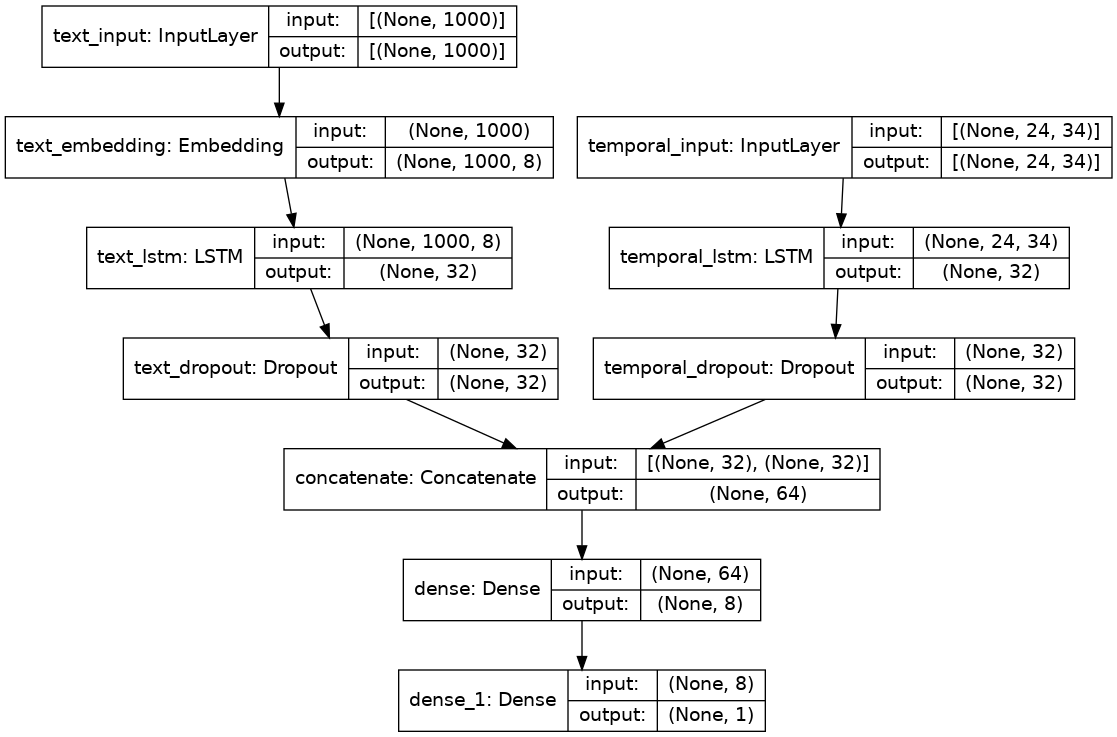

In [37]:
#plot the model structure
keras.utils.plot_model(composite_model, show_shapes=True)
